#  1. Importing Libraries  



In [1]:
import tensorflow as tf
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras.applications import EfficientNetB0, EfficientNetV2B0
from keras.applications.efficientnet_v2 import preprocess_input
from keras import layers, models, optimizers, Model
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import os
import random

2025-11-18 10:58:28.504409: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 10:58:29.052651: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 10:58:31.971251: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print("TensorFlow Version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Cetak detail GPU yang terdeteksi
        for gpu in gpus:
            print(f"GPU ditemukan: {gpu}")
        print(f"Jumlah GPU yang tersedia: {len(gpus)}")
    except RuntimeError as e:
        # Error biasanya terjadi jika GPU sudah diinisialisasi
        print(e)
else:
    print("Tidak ada GPU yang terdeteksi oleh TensorFlow. TensorFlow akan berjalan di CPU.")

TensorFlow Version: 2.20.0
GPU ditemukan: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Jumlah GPU yang tersedia: 1


In [3]:
data_dir = "Fruit And Vegetable Diseases Dataset/"

# 2.Exploratory Data Analysis: Class Distribution and Random Sample Visualization


In [4]:
class_names =sorted(os.listdir(data_dir))
n_classes = len(class_names)
class_dis = [len(os.listdir(data_dir + i)) for i in class_names]
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 28 
Class Names : ['Apple__Healthy', 'Apple__Rotten', 'Banana__Healthy', 'Banana__Rotten', 'Bellpepper__Healthy', 'Bellpepper__Rotten', 'Carrot__Healthy', 'Carrot__Rotten', 'Cucumber__Healthy', 'Cucumber__Rotten', 'Grape__Healthy', 'Grape__Rotten', 'Guava__Healthy', 'Guava__Rotten', 'Jujube__Healthy', 'Jujube__Rotten', 'Mango__Healthy', 'Mango__Rotten', 'Orange__Healthy', 'Orange__Rotten', 'Pomegranate__Healthy', 'Pomegranate__Rotten', 'Potato__Healthy', 'Potato__Rotten', 'Strawberry__Healthy', 'Strawberry__Rotten', 'Tomato__Healthy', 'Tomato__Rotten']


In [5]:
fig = px.pie(names = class_names , values = class_dis, 
             title="Training class Distribution",hole = 0.2)
fig.update_layout({'title':{'x':0.48}})
fig.show()

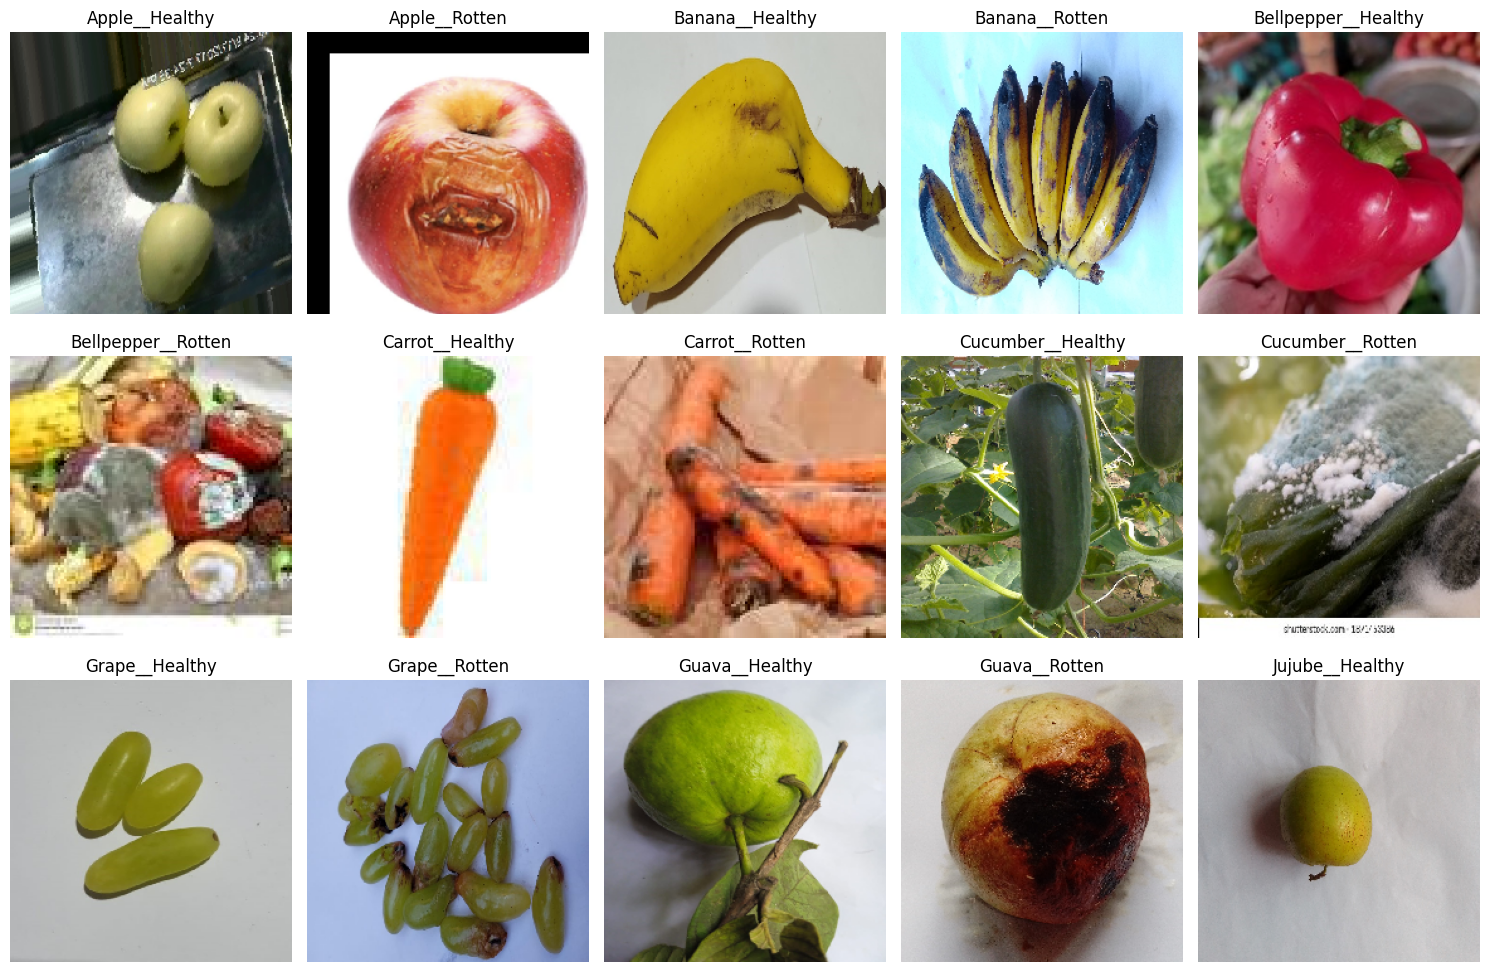

In [6]:
# Generate a random image from each class
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names[:15]):  # Display only the first 15 classes
    class_path = os.path.join(data_dir, class_name)
    
    # Select a random file from this class
    image_file = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_file)

    # Load the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize

    # Display the image
    plt.subplot(3, 5, i + 1)
    plt.imshow(img_array)
    plt.axis("off")
    plt.title(class_name)

plt.tight_layout()
plt.show()


# 3.Data Preparation: Creating Training and Validation Sets


<div style="background: linear-gradient(135deg, #34495e, #2c3e50); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #f39c12; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 26px; margin-bottom: 15px;">
        🔄 Data Preprocessing with ImageDataGenerator
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6;">
        The <strong>ImageDataGenerator</strong> is used to preprocess the dataset by rescaling pixel values 
        and splitting the data into training and validation sets. 
        It helps improve model generalization and prevents overfitting.
    </p>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6; margin-top: 10px;">
        ✅ You can also customize it with parameters like:
    </p>
    <ul style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6; list-style: none; padding: 0;">
        <li>📌 <strong>rotation_range=40</strong> → Randomly rotates images</li>
        <li>📌 <strong>width_shift_range=0.2</strong> → Shifts images horizontally</li>
        <li>📌 <strong>height_shift_range=0.2</strong> → Shifts images vertically</li>
        <li>📌 <strong>zoom_range=0.2</strong> → Applies random zoom</li>
        <li>📌 <strong>horizontal_flip=True</strong> → Flips images horizontally</li>
    </ul>
</div>


In [7]:
"""
rotation_range=30,
width_shift_range=0.3,
height_shift_range=0.3,
shear_range=0.3,
zoom_range=0.3,
brightness_range=[0.7, 1.3],
horizontal_flip=True,
vertical_flip=True, 
fill_mode='nearest',
"""

"\nrotation_range=30,\nwidth_shift_range=0.3,\nheight_shift_range=0.3,\nshear_range=0.3,\nzoom_range=0.3,\nbrightness_range=[0.7, 1.3],\nhorizontal_flip=True,\nvertical_flip=True, \nfill_mode='nearest',\n"

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
    )

In [9]:
batch_size = 64
img_size = (224, 224)

In [10]:
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset="training"
)

valid_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset="validation"
)

Found 20504 images belonging to 28 classes.
Found 8773 images belonging to 28 classes.


In [11]:
print(f"Classes: {train_data.class_indices}")
print(f"Train samples: {train_data.samples}, Valid samples: {valid_data.samples}")

Classes: {'Apple__Healthy': 0, 'Apple__Rotten': 1, 'Banana__Healthy': 2, 'Banana__Rotten': 3, 'Bellpepper__Healthy': 4, 'Bellpepper__Rotten': 5, 'Carrot__Healthy': 6, 'Carrot__Rotten': 7, 'Cucumber__Healthy': 8, 'Cucumber__Rotten': 9, 'Grape__Healthy': 10, 'Grape__Rotten': 11, 'Guava__Healthy': 12, 'Guava__Rotten': 13, 'Jujube__Healthy': 14, 'Jujube__Rotten': 15, 'Mango__Healthy': 16, 'Mango__Rotten': 17, 'Orange__Healthy': 18, 'Orange__Rotten': 19, 'Pomegranate__Healthy': 20, 'Pomegranate__Rotten': 21, 'Potato__Healthy': 22, 'Potato__Rotten': 23, 'Strawberry__Healthy': 24, 'Strawberry__Rotten': 25, 'Tomato__Healthy': 26, 'Tomato__Rotten': 27}
Train samples: 20504, Valid samples: 8773


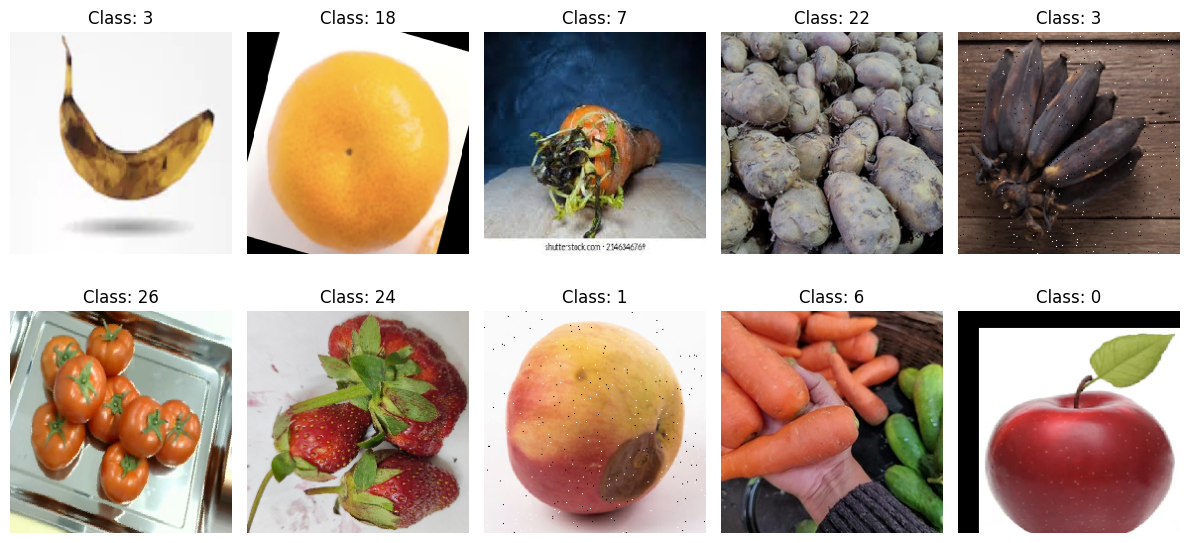

In [12]:
images, labels = next(train_data)  # Get a batch of images

# Display the first 10 images from this batch
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])  # Show image
    plt.axis("off")  # Remove axis
    plt.title(f"Class: {np.argmax(labels[i])}")  # Display image class

plt.tight_layout()
plt.show()


# 4. Building the EfficientNetV2B0 Model 🚀


<div style="background: linear-gradient(135deg, #1a1a2e, #16213e); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #00c8ff; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 26px; margin-bottom: 15px;">
        🚀 EfficientNetV2B0: Optimized for Speed & Accuracy
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6;">
        <strong>EfficientNetV2B0</strong> is a compact and highly efficient deep learning model designed for 
        <strong>image classification</strong>. It improves upon its predecessor (EfficientNetV1) by utilizing 
        <strong>progressive learning</strong>, <strong>faster training</strong>, and <strong>better efficiency</strong> 
        in handling real-world datasets.
    </p>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6; margin-top: 10px;">
        ✅ Key Features:
    </p>
    <ul style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6; list-style: none; padding: 0;">
        <li>⚡ <strong>Lightweight</strong> → Faster inference and training</li>
        <li>🎯 <strong>Higher Accuracy</strong> → Optimized for complex patterns</li>
        <li>🔥 <strong>Better Scaling</strong> → Efficiently scales to larger datasets</li>
        <li>🧠 <strong>Pretrained on ImageNet</strong> → Transfer learning ready</li>
    </ul>
</div>


<div style="background: linear-gradient(135deg, #1a1a2e, #16213e); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #00c8ff; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 26px; margin-bottom: 15px;">
        🏗️ Constructing the EfficientNetV2B0 Model 🚀
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6;">
        We integrate <strong>EfficientNetV2B0</strong> as the backbone with pre-trained <strong>ImageNet</strong> weights. 
        The base model is initially <strong>frozen</strong> to retain essential feature representations, while custom dense layers refine classification. 
        A fine-tuning strategy can later be applied to optimize performance for domain-specific tasks.
    </p>
</div>


In [13]:
# 1. Base EfficientNetV2B0 Model with Pretrained Weights
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',  # Use pre-trained weights
    input_shape=(224, 224, 3),
    pooling='avg',
    include_preprocessing=True)


I0000 00:00:1763438321.431789   18237 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3676 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
# 2. Base model EfficientNetV2B0 with pre-trained weights
base_model.trainable = False  # Freeze EfficientNet layers


# 3. Keep the last layers of the base model open for Fine-Tuning
#base_model.trainable = False

# 4. Model input
inputs = layers.Input(shape=(224, 224, 3))

# 5. Using the base model
x = base_model(inputs)

x = layers.Dropout(0.1)(x)  # Reduce Dropout to preserve useful information

x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # Reduce Regularization
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(28, activation='softmax')(x)  # Output with 28 classes

# 6. Build the model
efficientnet_model = models.Model(inputs, outputs)

# 7. AdamW optimizer with adjustable learning rate
optimizer = optimizers.AdamW(learning_rate=1e-3)  # Higher learning rate

# 8. Compile the model
efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Display model summary
efficientnet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,087,404 (23.22 MB)

 Trainable params: 167,836 (655.61 KB)

 Non-trainable params: 5,919,568 (22.58 MB)

## 4.2  Pre-Fine-Tuning Training for EfficientNetV2B0 🛠️

In [15]:
history_efficientnet = efficientnet_model.fit(
    train_data,
    epochs=5,
    validation_data=valid_data 
)

Epoch 1/5


2025-11-18 10:58:59.610687: I external/local_xla/xla/service/service.cc:163] XLA service 0x72f804003430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-18 10:58:59.610728: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-11-18 10:59:00.240709: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-18 10:59:03.360335: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-18 10:59:05.391133: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-18 10:59

  3/321 ━━━━━━━━━━━━━━━━━━━━ 1:59 374ms/step - accuracy: 0.0460 - loss: 4.0125

/home/dika/Neuro Computing/Fruits & Vegetables Diseases/tf/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



295/321 ━━━━━━━━━━━━━━━━━━━━ 16s 638ms/step - accuracy: 0.0810 - loss: 3.5653

2025-11-18 11:02:56.187956: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:02:56.307481: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:02:58.048311: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:02:58.165558: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:02:58.296268: E external/local_xla/xla/stream_

321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.0829 - loss: 3.5462

2025-11-18 11:05:08.308896: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:05:08.416391: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:05:08.524425: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:05:08.632444: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:05:10.389030: E external/local_xla/xla/stream_

321/321 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.1056 - loss: 3.3188 - val_accuracy: 0.1113 - val_loss: 3.1294
Epoch 2/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 279s 870ms/step - accuracy: 0.1298 - loss: 3.0510 - val_accuracy: 0.1087 - val_loss: 2.9883
Epoch 3/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 265s 825ms/step - accuracy: 0.1373 - loss: 2.9953 - val_accuracy: 0.1249 - val_loss: 2.9145
Epoch 4/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 265s 825ms/step - accuracy: 0.1387 - loss: 2.9674 - val_accuracy: 0.1348 - val_loss: 2.9221
Epoch 5/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 264s 824ms/step - accuracy: 0.1392 - loss: 2.9441 - val_accuracy: 0.1236 - val_loss: 6.4533


## 4.3  Fine-Tuning EfficientNetV2B0 for Enhanced Accuracy ✅

In [16]:
# Unfreeze EfficientNet Layers for Fine-Tuning
base_model.trainable = True

# Reduce Learning Rate for Fine-Tuning
optimizer = optimizers.AdamW(learning_rate=1e-4)  

# Recompile the Model with a Lower Learning Rate
efficientnet_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Full Training with Fine-Tuning
efficientnet_model.fit(train_data, validation_data=valid_data, epochs=5)


Epoch 1/5


2025-11-18 11:24:15.768268: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:24:15.910793: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:24:29.410876: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:24:29.548560: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


172/321 ━━━━━━━━━━━━━━━━━━━━ 1:28 594ms/step - accuracy: 0.4804 - loss: 2.0013

2025-11-18 11:27:07.267994: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:27:07.386834: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:27:15.145100: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:27:15.263417: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


321/321 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - accuracy: 0.7589 - loss: 1.0503 - val_accuracy: 0.8966 - val_loss: 0.5032
Epoch 2/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 269s 837ms/step - accuracy: 0.9447 - loss: 0.3367 - val_accuracy: 0.8889 - val_loss: 0.5204
Epoch 3/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 274s 853ms/step - accuracy: 0.9723 - loss: 0.2038 - val_accuracy: 0.8353 - val_loss: 0.6842
Epoch 4/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 305s 947ms/step - accuracy: 0.9829 - loss: 0.1473 - val_accuracy: 0.9064 - val_loss: 0.4000
Epoch 5/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 312s 969ms/step - accuracy: 0.9883 - loss: 0.1151 - val_accuracy: 0.9398 - val_loss: 0.2878


## 4.4  Model Performance: Accuracy, Errors & Insights 📊

In [17]:
loss, accuracy = efficientnet_model.evaluate(valid_data)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")

138/138 ━━━━━━━━━━━━━━━━━━━━ 81s 589ms/step - accuracy: 0.9398 - loss: 0.2878
Validation Accuracy: 0.9398
Validation Loss: 0.2878


2025-11-18 11:51:57.364311: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:51:57.485475: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:51:59.337158: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:51:59.455541: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step


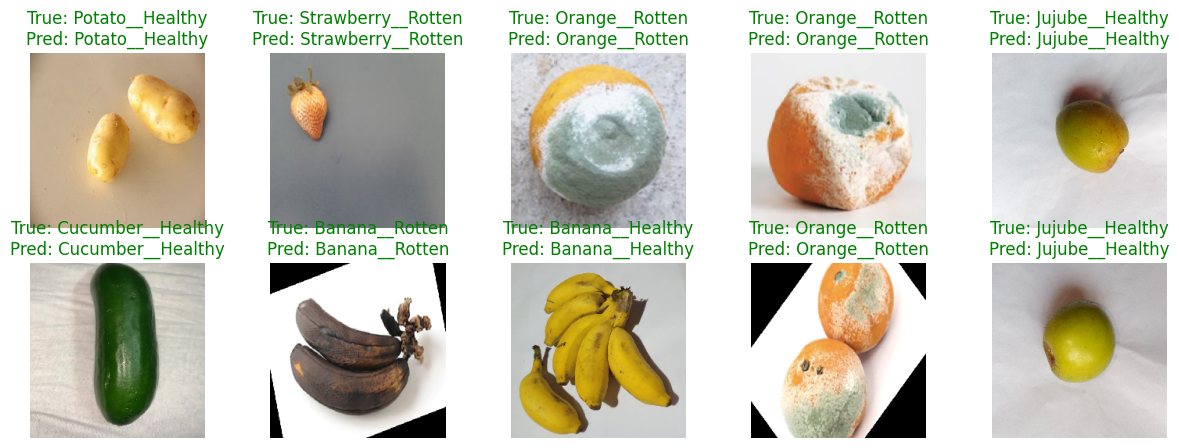

In [18]:
# Fetch a Batch from Validation Data
valid_data.reset()
images, labels = next(valid_data)

# Get Predictions
predictions = efficientnet_model.predict(images)

# Convert Output to Predicted Classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Display Images with Predictions
plt.figure(figsize=(15, 5))
for i in range(10):  # Show the first 10 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    true_label = list(valid_data.class_indices.keys())[true_classes[i]]
    pred_label = list(valid_data.class_indices.keys())[predicted_classes[i]]

    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━

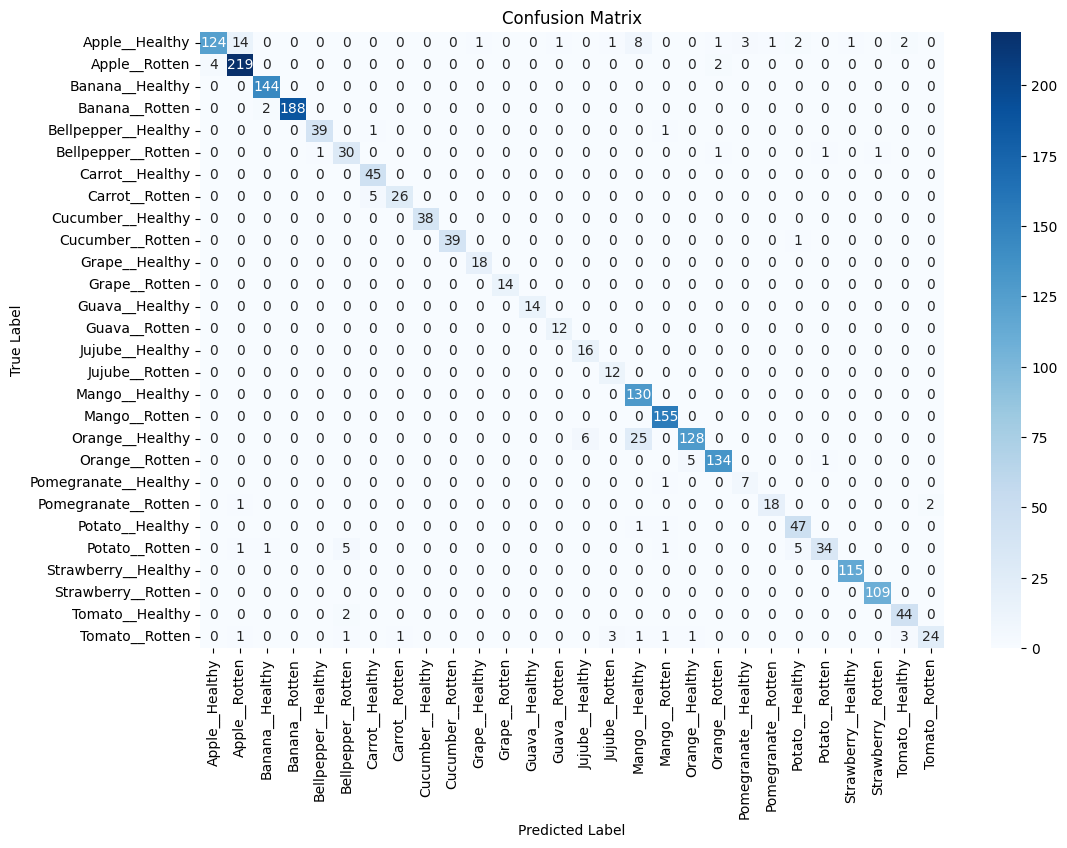

                      precision    recall  f1-score   support

      Apple__Healthy       0.97      0.78      0.86       159
       Apple__Rotten       0.93      0.97      0.95       225
     Banana__Healthy       0.98      1.00      0.99       144
      Banana__Rotten       1.00      0.99      0.99       190
 Bellpepper__Healthy       0.97      0.95      0.96        41
  Bellpepper__Rotten       0.79      0.88      0.83        34
     Carrot__Healthy       0.88      1.00      0.94        45
      Carrot__Rotten       0.96      0.84      0.90        31
   Cucumber__Healthy       1.00      1.00      1.00        38
    Cucumber__Rotten       1.00      0.97      0.99        40
      Grape__Healthy       0.95      1.00      0.97        18
       Grape__Rotten       1.00      1.00      1.00        14
      Guava__Healthy       1.00      1.00      1.00        14
       Guava__Rotten       0.92      1.00      0.96        12
     Jujube__Healthy       0.73      1.00      0.84        16
      J

In [19]:
# Limit the Number of Batches to Prevent High Memory Usage
num_batches = 32  # Number of batches to process

y_pred_probs = []
y_true = []

# Fetch a Limited Number of Batches from valid_data
for i, (images, labels) in enumerate(valid_data):
    if i >= num_batches:  # Restrict processing to 10 batches
        break
    preds = efficientnet_model.predict(images)
    y_pred_probs.append(preds)
    y_true.append(labels)

# Merge All Batches
y_pred_probs = np.concatenate(y_pred_probs, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Compute Predicted Classes
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Display Classification Report
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


In [20]:
# Calculate Error Rate for Each Class
errors_per_class = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
error_rate_per_class = errors_per_class / np.sum(conf_matrix, axis=1)

# Display Classes with the Highest Error Rate
sorted_errors = sorted(zip(class_names, error_rate_per_class), key=lambda x: x[1], reverse=True)
print("📌 Classes with the Highest Error Rate:")
for cls, error in sorted_errors[:5]:  # Display top 5 classes with the highest error
    print(f"{cls}: {error:.2%} error")


📌 Classes with the Highest Error Rate:
Tomato__Rotten: 33.33% error
Potato__Rotten: 27.66% error
Apple__Healthy: 22.01% error
Orange__Healthy: 19.50% error
Carrot__Rotten: 16.13% error


In [21]:
save_dir = 'saved_model'
os.makedirs(save_dir, exist_ok=True)

# Simpan dalam format TensorFlow (.pb + variables)
# efficientnet_model.save(os.path.join(save_dir, 'efficientnetv2b0_model_4'))

# Atau simpan dalam format HDF5 (.h5)
efficientnet_model.save(os.path.join(save_dir, 'efficientnetv2b0_model_5.h5'))

✅ Model berhasil dimuat.


2025-11-18 11:52:49.953271: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:52:50.070436: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 11:52:50.183839: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


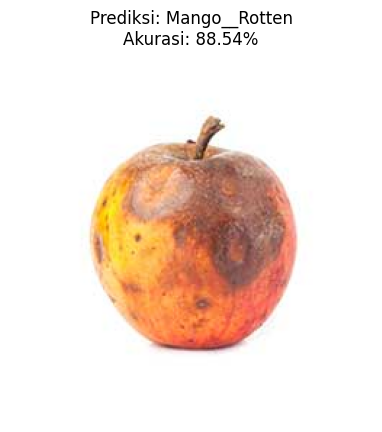

Hasil Prediksi:
  - Kelas Prediksi : Mango__Rotten
  - Skor Kepercayaan: 0.8854


In [22]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """Memuat dan memproses gambar tunggal."""
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # tambah dimensi batch
    img_array = img_array / 255.0  # normalisasi
    return img_array

# Ganti path gambar di bawah ini dengan gambar yang ingin kamu prediksi
NEW_IMAGE_PATH = '/home/dika/Neuro Computing/Fruits & Vegetables Diseases/test_image/apple.jpg'

if os.path.exists(NEW_IMAGE_PATH):
    # Muat model yang telah disimpan
    model = models.load_model('saved_model/efficientnetv2b0_model_5.h5')
    print("✅ Model berhasil dimuat.")

    # Proses gambar baru
    new_image = load_and_preprocess_image(NEW_IMAGE_PATH)

    # Prediksi kelas
    preds = model.predict(new_image)
    predicted_class_idx = np.argmax(preds[0])
    predicted_class_name = class_names[predicted_class_idx]
    confidence = np.max(preds[0])

    # Tampilkan hasil prediksi
    plt.imshow(load_img(NEW_IMAGE_PATH))
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_class_name}\nAkurasi: {confidence:.2%}")
    plt.show()

    print(f"Hasil Prediksi:")
    print(f"  - Kelas Prediksi : {predicted_class_name}")
    print(f"  - Skor Kepercayaan: {confidence:.4f}")
else:
    print(f"File tidak ditemukan di path: {NEW_IMAGE_PATH}")


✅ Model berhasil dimuat.
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


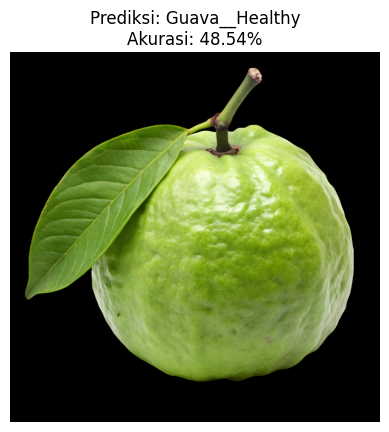

Hasil Prediksi:
  - Kelas Prediksi : Guava__Healthy
  - Skor Kepercayaan: 0.4854


In [23]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """Memuat dan memproses gambar tunggal."""
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # tambah dimensi batch
    img_array = img_array / 255.0  # normalisasi
    return img_array

# Ganti path gambar di bawah ini dengan gambar yang ingin kamu prediksi
NEW_IMAGE_PATH = '/home/dika/Neuro Computing/Fruits & Vegetables Diseases/test_image/guava.png'

if os.path.exists(NEW_IMAGE_PATH):
    # Muat model yang telah disimpan
    model = models.load_model('saved_model/efficientnetv2b0_model_5.h5')
    print("✅ Model berhasil dimuat.")

    # Proses gambar baru
    new_image = load_and_preprocess_image(NEW_IMAGE_PATH)

    # Prediksi kelas
    preds = model.predict(new_image)
    predicted_class_idx = np.argmax(preds[0])
    predicted_class_name = class_names[predicted_class_idx]
    confidence = np.max(preds[0])

    # Tampilkan hasil prediksi
    plt.imshow(load_img(NEW_IMAGE_PATH))
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_class_name}\nAkurasi: {confidence:.2%}")
    plt.show()

    print(f"Hasil Prediksi:")
    print(f"  - Kelas Prediksi : {predicted_class_name}")
    print(f"  - Skor Kepercayaan: {confidence:.4f}")
else:
    print(f"File tidak ditemukan di path: {NEW_IMAGE_PATH}")

✅ Model berhasil dimuat.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


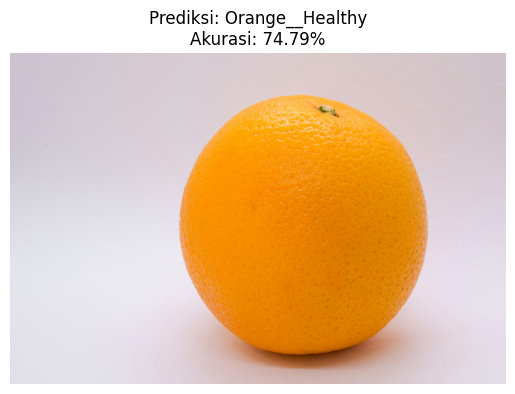

Hasil Prediksi:
  - Kelas Prediksi : Orange__Healthy
  - Skor Kepercayaan: 0.7479


In [24]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """Memuat dan memproses gambar tunggal."""
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # tambah dimensi batch
    img_array = img_array / 255.0  # normalisasi
    return img_array

# Ganti path gambar di bawah ini dengan gambar yang ingin kamu prediksi
NEW_IMAGE_PATH = '/home/dika/Neuro Computing/Fruits & Vegetables Diseases/test_image/orange.jpg'

if os.path.exists(NEW_IMAGE_PATH):
    # Muat model yang telah disimpan
    model = models.load_model('saved_model/efficientnetv2b0_model_5.h5')
    print("✅ Model berhasil dimuat.")

    # Proses gambar baru
    new_image = load_and_preprocess_image(NEW_IMAGE_PATH)

    # Prediksi kelas
    preds = model.predict(new_image)
    predicted_class_idx = np.argmax(preds[0])
    predicted_class_name = class_names[predicted_class_idx]
    confidence = np.max(preds[0])

    # Tampilkan hasil prediksi
    plt.imshow(load_img(NEW_IMAGE_PATH))
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_class_name}\nAkurasi: {confidence:.2%}")
    plt.show()

    print(f"Hasil Prediksi:")
    print(f"  - Kelas Prediksi : {predicted_class_name}")
    print(f"  - Skor Kepercayaan: {confidence:.4f}")
else:
    print(f"File tidak ditemukan di path: {NEW_IMAGE_PATH}")

## 4.5  Visualizing Gradient Descent (Training Curves) 📉📈

Gradient descent updates the model weights every step to **reduce the loss function**. 
By plotting the **training** and **validation** loss/accuracy across epochs, we can visualize how the optimizer (AdamW in this case) converges during training.

Run this cell *after* training the model to see how the optimization progressed over time.


In [ ]:
# Visualizing Gradient Descent via Training Curves

# Make sure `history_efficientnet` exists (from the first training phase)
try:
    history = history_efficientnet.history
except NameError:
    raise RuntimeError("history_efficientnet is not defined. Run the training cell before this visualization.")

# Plot Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Val Loss')
plt.title('Gradient Descent: Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history:
    plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Gradient Descent: Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()
